# Predicting Customer Churning
This notebook aims to predict churning rate of customers of a bank on their credit card services.

## Importing The Packages
We will install and import all the packages that we are going to use in this notebook first.

In [3]:
# Installing xgboost
! pip install xgboost
! pip install -U imbalanced-learn

# importing lybraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from collections import Counter
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler as ss, MinMaxScaler as mms
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
# Importing packages for SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTEENN
from numpy import loadtxt
from lightgbm import plot_importance

Requirement already up-to-date: imbalanced-learn in c:\users\suhai\anaconda3\lib\site-packages (0.8.0)


## Reading The Data
Here we read the data and then take a first look on it in order to start our prediction process.

In [4]:
df = pd.read_csv('BankChurners.csv')

In [5]:
df

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,710638233,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


### Checking for the Null values

In [8]:
df.isnull().sum()

CLIENTNUM                                                                                                                             0
Attrition_Flag                                                                                                                        0
Customer_Age                                                                                                                          0
Gender                                                                                                                                0
Dependent_count                                                                                                                       0
Education_Level                                                                                                                       0
Marital_Status                                                                                                                        0
Income_Category                                 

Since there are no Null values, the data is clean!

## Preprocessing The Dataset
Now we will prepare the data for our prediction stage.

In [5]:
df = df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'], axis = 1)
df = df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis = 1)
df = df.drop(['CLIENTNUM'], axis = 1)
df

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462
10123,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


In [6]:
df.loc[df['Attrition_Flag'] == 'Attrited Customer']

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
21,Attrited Customer,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,3,3,1438.3,0,1438.3,1.047,692,16,0.600,0.000
39,Attrited Customer,66,F,0,Doctorate,Married,Unknown,Blue,56,5,4,3,7882.0,605,7277.0,1.052,704,16,0.143,0.077
51,Attrited Customer,54,F,1,Graduate,Married,Less than $40K,Blue,40,2,3,1,1438.3,808,630.3,0.997,705,19,0.900,0.562
54,Attrited Customer,56,M,2,Graduate,Married,$120K +,Blue,36,1,3,3,15769.0,0,15769.0,1.041,602,15,0.364,0.000
61,Attrited Customer,48,M,2,Graduate,Married,$60K - $80K,Silver,35,2,4,4,34516.0,0,34516.0,0.763,691,15,0.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10119,Attrited Customer,55,F,3,Uneducated,Single,Unknown,Blue,47,4,3,3,14657.0,2517,12140.0,0.166,6009,53,0.514,0.172
10123,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000
10125,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000


In [7]:
X = df.drop('Attrition_Flag', axis = 1)
y = df['Attrition_Flag']

In [8]:
print(y)

0        Existing Customer
1        Existing Customer
2        Existing Customer
3        Existing Customer
4        Existing Customer
               ...        
10122    Existing Customer
10123    Attrited Customer
10124    Attrited Customer
10125    Attrited Customer
10126    Attrited Customer
Name: Attrition_Flag, Length: 10127, dtype: object


## Predicting The Churning Rate

Now is the time for our dataset to be used to predict the churning rate of a customer of this bank.

We will split the data of X and y into train and test datasets, 80% for train and 20% for test.

LabelEncoder were used to convert the 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category' and 'Card_Category' column into numerical from categorical.

In [9]:
# Predicting customer churn

cat_cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category','Card_Category']
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    
le = LabelEncoder()
y = le.fit_transform(y)
X = X.drop(['Credit_Limit', 'Total_Revolving_Bal'], axis = 1)

#### Train Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

In [11]:
count = Counter(y_train)
print('Distribution of target 1 & 2:', count[1], '&', count[0])

Distribution of target 1 & 2: 6817 & 1284


By using Counter, we can see that count'0' is 4 or 5 times less than count'1', so we use SMOTE to resample it and make it even.

In [12]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [13]:
count = Counter(y_train)
print('Distribution of target 1 & 2:', count[1], '&', count[0])

Distribution of target 1 & 2: 6817 & 6817


After resampling the data, now it is time for us to choose classifiers to be used in order to get our final output. Here we have selected XGBoost, Random Forest, and LGBM Classifier as our classifier. 

We will then loop and fit them with the train and test set to evaluate the results.

In [14]:
classifiers = [[XGBClassifier(), 'XGB Classifier'], [RandomForestClassifier(), 'Random Forest'], [LGBMClassifier(), 'LGBM Classifier']]

In [15]:
score_list = []
cross_val_list = []
roc_auc_list = []

for classifier in classifiers:
    model = classifier[0]
    model.fit(X_train, y_train)
    model_name = classifier[1]
    
    pred = model.predict(X_test)
    
    score = model.score(X_test, y_test)
    cross_val = cross_val_score(model, X_test, y_test).mean()
    roc_auc = roc_auc_score(y_test, pred)
    
    score_list.append(score)
    cross_val_list.append(cross_val)
    roc_auc_list.append(roc_auc)
    
    print(model_name, 'model score:     '  + str(round(score*100, 2)) + '%')
    print(model_name, 'cross val score: '  + str(round(cross_val*100, 2)) + '%')
    print(model_name, 'roc auc score:   ' + str(round(roc_auc*100,2 )) + '%')
    
    if model_name != classifiers[-1][1]:
        print('')


[15:30:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of lab

[15:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Classifier model score:     97.24%
XGB Classifier cross val score: 95.95%
XGB Classifier roc auc score:   95.78%

Random Forest model score:     96.64%
Random Forest cross val score: 95.41%
Random Forest roc auc score:   94.85%

LGBM Classifier model score:     97.29%
LGBM Classifier cross val score: 96.45%
LGBM Classifier roc auc score:   96.04%


### SMOTEENN
Now we will perform the resampling with SMOTE again but this time we will be using Edited Nearest Neighbours(ENN) too to combine over and under sampling.

Then we will be using the same loop code to find the result.

In [16]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state = 21)

In [17]:
sme = SMOTEENN(random_state=21)
X_train2, y_train2 = sme.fit_resample(X_train2, y_train2)

In [18]:
count = Counter(y_train2)
print('Distribution of target 1 & 2:', count[1], '&', count[0])

Distribution of target 1 & 2: 4832 & 5254


In [19]:
score_list = []
cross_val_list = []
roc_auc_list = []

for classifier in classifiers:
    model = classifier[0]
    model.fit(X_train2, y_train2)
    model_name = classifier[1]
    
    pred = model.predict(X_test2)
    
    score = model.score(X_test2, y_test2)
    cross_val = cross_val_score(model, X_test2, y_test2).mean()
    roc_auc = roc_auc_score(y_test2, pred)
    
    score_list.append(score)
    cross_val_list.append(cross_val)
    roc_auc_list.append(roc_auc)
    
    print(model_name, 'model score:     '  + str(round(score*100, 2)) + '%')
    print(model_name, 'cross val score: '  + str(round(cross_val*100, 2)) + '%')
    print(model_name, 'roc auc score:   ' + str(round(roc_auc*100,2 )) + '%')
    
    if model_name != classifiers[-1][1]:
        print('')


[15:30:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of lab

[15:30:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:30:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:30:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Classifier model score:     95.11%
XGB Classifier cross val score: 95.95%
XGB Classifier roc auc score:   94.62%

Random Forest model score:     94.72%
Random Forest cross val score: 95.31%
Random Forest roc auc score:   94.5%

LGBM Classifier model score:     95.36%
LGBM Classifier cross val score: 96.45%
LGBM Classifier roc auc score:   94.77%


### Pipeline

Lastly, we make a pipeline by using Borderline SMOTE and RandomUnderSampling so that we will decrease the overfitting in the data. 

In [20]:
over = BorderlineSMOTE(sampling_strategy = 0.3)
under = RandomUnderSampler(sampling_strategy = 0.6)
steps = [('o', over), ('u', under)]

In [21]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.2, random_state = 21)

In [22]:
pipeline = Pipeline(steps=steps)
X_train3, y_train3 = pipeline.fit_resample(X_train3, y_train3)

In [23]:
count = Counter(y_train3)
print('Distribution of target 1 & 2:', count[1], '&', count[0])

Distribution of target 1 & 2: 3408 & 2045


In [24]:
classifiers2 = [[XGBClassifier(), 'XGB Classifier'],[LGBMClassifier(), 'LGBM Classifier']]

In [25]:
score_list = []
cross_val_list = []
roc_auc_list = []

for classifier in classifiers2:
    model = classifier[0]
    model.fit(X_train3, y_train3)
    model_name = classifier[1]
    
    pred = model.predict(X_test3)
    
    score = model.score(X_test3, y_test3)
    cross_val = cross_val_score(model, X_test3, y_test3).mean()
    roc_auc = roc_auc_score(y_test3, pred)
    
    score_list.append(score)
    cross_val_list.append(cross_val)
    roc_auc_list.append(roc_auc)
    
    print(model_name, 'model score:     '  + str(round(score*100, 2)) + '%')
    print(model_name, 'cross val score: '  + str(round(cross_val*100, 2)) + '%')
    print(model_name, 'roc auc score:   ' + str(round(roc_auc*100,2 )) + '%')
    
    if model_name != classifiers[-1][1]:
        print('')


[15:31:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of lab

[15:31:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:31:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:31:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:31:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\suhai\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:31:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Classifier model score:     97.14%
XGB Classifier cross val score: 95.95%
XGB Classifier roc auc score:   96.07%

LGBM Classifier model score:     97.09%
LGBM Classifier cross val score: 96.45%
LGBM Classifier roc auc score:   95.58%


## Plot Importance
By using plot_importance, we can see most important feature column used in LGBM Classifier, so that we can deduce what would affect the customer's churning rate.

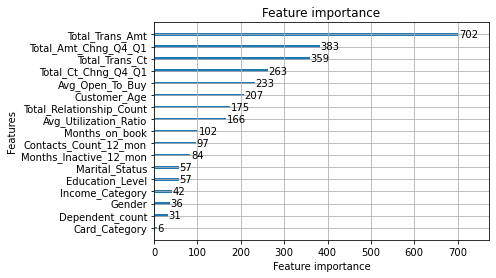

In [26]:
# plot feature importance
lgbm = LGBMClassifier()
lgbm.fit(X_train3, y_train3)
plot_importance(lgbm)
plt.show()